In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import networkx as nx

def fastGSSS(L_n, F, bw, nu, eigen_decomp, *args):
   
    def selection(selected_mask, T_g_tmp):
        T_g_tmp_copy = np.copy(T_g_tmp)  # Create a copy to avoid modifying the original array

        # Apply the selected_mask to select nodes
        T_g_tmp_copy[selected_mask] = 0

        # Randomly select a node from the remaining pool
        remaining_nodes = np.where(~selected_mask)[0]
        selected_node = np.random.choice(remaining_nodes)

        selected_mask[selected_node] = True  # Update the selected_mask
        return selected_mask

    # Input check
    if eigen_decomp == 1:
        if len(args) != 2:
            raise ValueError('For eigen_decomp = 1, U and E must be declared!')
        else:
            U, E = args

    else:
        if len(args) != 1:
            raise ValueError('For eigen_decomp = 0, m must be declared!')
        else:
            m = args[0]

    # Parameters
    N = L_n.shape[0]
    A_tmp = csr_matrix(L_n - np.diag(np.diag(L_n)))
    numedge = np.sum(A_tmp) / 2
    p = numedge / N  # edge probability
    n = F / N  # sampling ratio
    k = bw / N  # bandwidth

    # Preparing T
    if eigen_decomp == 1:
        lmax = np.max(E)
        g_E = np.exp(-nu * p * n * k * E / lmax)
        T_g_tmp1 = np.dot(U, np.dot(np.diag(g_E), U.T))

    else:
        arange = [0, 2]
        g = lambda x: np.exp(-nu * p * n * k * x / 2)
        c = sgwt_cheby_coeff(g, m, m + 1, arange)
        T_g_tmp1 = sgwt_cheby_op2(L_n, c, arange)

    # SSS
    T_g_tmp = np.abs(T_g_tmp1)

    selected_mask = np.zeros(N, dtype=bool)  # Create a mask for all nodes, initially all False

    selected_nodes = []
    for _ in range(F):
        selected_mask = selection(selected_mask, T_g_tmp)
        selected_node = np.where(selected_mask)[0]
        selected_nodes.append(selected_node)

    T = T_g_tmp1

    return selected_nodes, T

# Define your sgwt_cheby_coeff and sgwt_cheby_op2 functions as needed.

def sgwt_cheby_coeff(g, m, N=None, arange=None):
    if N is None:
        N = m + 1
    if arange is None:
        arange = [-1, 1]
   
    a1 = (arange[1] - arange[0]) / 2
    a2 = (arange[1] + arange[0]) / 2
    c = np.zeros(m + 1)
   
    for j in range(1, m + 2):
        angles = (np.pi * (np.arange(1, N + 1) - 0.5)) / N
        c[j - 1] = np.sum(g(a1 * np.cos(angles) + a2) * np.cos(np.pi * (j - 1) * ((np.arange(1, N + 1) - 0.5) / N))) * 2 / N
   
    return c

def sgwt_cheby_op2(L, c, arange):
    maxM = len(c)
    a1 = (arange[1] - arange[0]) / 2
    a2 = (arange[1] + arange[0]) / 2
    N = L.shape[0]
    L_hat = L - a2 * np.eye(N)
    Twf_old = np.eye(N)
    Twf_cur = L_hat / a1
    r = 0.5 * c[0] * Twf_old + c[1] * Twf_cur
   
    for k in range(2, maxM):
        Twf_new = (2 / a1) * L_hat.dot(Twf_cur) - Twf_old
        if k < len(c):
            r += c[k] * Twf_new
        Twf_old = Twf_cur
        Twf_cur = Twf_new
   
    return r

(300, 2)
(200, 2)


/tmp/ipykernel_2467/1587726037.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap='Spectral')
/usr/local/lib64/python3.9/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "ms_umap_v1.py", line 624:
    @numba.njit(parallel=True)
    def nn_descent(data, n_neighbors, rng_state, max_candidates=50,
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
2023-09-29 00:21:29,417:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


500 nodes, 2785 edges
default
3000000
500 nodes, 2785 edges


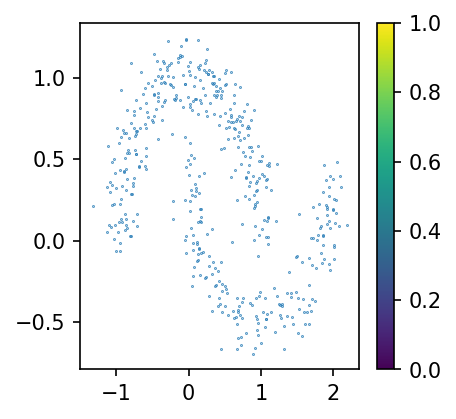

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_random_state
from sklearn.datasets import make_moons
from sklearn import cluster, datasets, mixture
from ms_umap_v1 import fuzzy_simplicial_set, construct_SGW
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, utils

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
X, y = make_moons(600, noise=0.12)
X2, y2 = make_moons(600, noise=0.12)

outer_numbers = np.where(y == 0)
inner_numbers = np.where(y == 1)
#print(outer_numbers)

outer_numbers2 = np.where(y2 == 0)
inner_numbers2 = np.where(y2 == 1)

x1 = X[outer_numbers]
x2 = X[inner_numbers]
print(x1.shape)
num = 200
num = 200
x2 = x2[0:num]
print(x2.shape)

XX = np.append(x1,x2, axis=0)
XX.shape
X =XX
plt.figure(dpi=150, figsize=(3,3))
plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap='Spectral')
#plt.scatter(embedding_norm[idx0,0], embedding_norm[idx0,1],  s=0.2, cmap='Spectral')
plt.colorbar()

from sklearn.utils import check_random_state

N_NEIGHBOR = 10
N_LOW_DIMS = 2
LEARNING_RATE = 0.1
#LEARNING_RATE = 10
MAX_ITER = 100

feats = X
#knn = 10
num_filters = 5
m = 5
n_neighbors = 10
metric='euclidean'
n_edge_samples=None
spread=1.0
min_dist=0.1
random_state=None
metric_kwds={}
angular_rp_forest=False
method = 'method 1'
verbose=False

random_state=None
INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1
random_state = check_random_state(random_state)

rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)
graph = fuzzy_simplicial_set(X, n_neighbors, check_random_state(None), metric,metric_kwds,angular_rp_forest,verbose)
#G = graphs.NNGraph(feats, NNtype='knn', k=10)
G = graphs.Graph(graph)
G.coords = feats
g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)
print(f'{G.N} nodes, {G.Ne} edges')

n_vertices = G.N
negative_sample_rate = 5
a = 1 
b =1 
gamma=1.0

g2 = graphs.Graph(graph)
g2.estimate_lmax()
#pos_edges = positive_edges_arrays
n_edge_samples = (graph.shape[0] // 150) * 1000000
print("default")
print(n_edge_samples)
sgw_kernel = 'mexican hat'
sgw_num_filters = 5
sgw_num_keep = 3
method = 'method 1'

graph = graph.tocoo()
graph.sum_duplicates()
positive_head = graph.row
positive_tail = graph.col
initial_alpha=1.0
print(f'{G.N} nodes, {G.Ne} edges')

In [13]:
# Create a random graph with N nodes
N = G.N  # Adjust the number of nodes as needed
G.compute_laplacian('normalized')
L = G.L
W = G.W

In [33]:
#G = nx.gnp_random_graph(N, p=0.05)  # Adjust the probability 'p' as needed

# Compute the Laplacian matrix (normalized Laplacian)
#L = nx.normalized_laplacian_matrix(G)

# Convert the Laplacian matrix to a dense numpy array
L_n = L.toarray()

# Parameters for fastGSSS
F = 10  # Number of vertices to select
bw = 10  # Bandwidth
nu = 0.5  # Parameter controlling the width of the filter kernel
nu = 1  # Parameter controlling the width of the filter kernel
eigen_decomp = 1  # Set to 0 for Chebyshev polynomial approximation
m = 4  # Arbitrary value for the Chebyshev polynomial order

# Perform eigenvalue decomposition of L
U, E = np.linalg.eigh(L.toarray())

# Call fastGSSS with the generated Laplacian matrix and parameters
selected_nodes, T = fastGSSS(L_n, F, bw, nu, eigen_decomp, U, E)


selected_nodes = selected_nodes[F-1]
print(selected_nodes)

import matplotlib.pyplot as plt
import networkx as nx

[ 74 164 189 203 224 229 345 356 405 473]


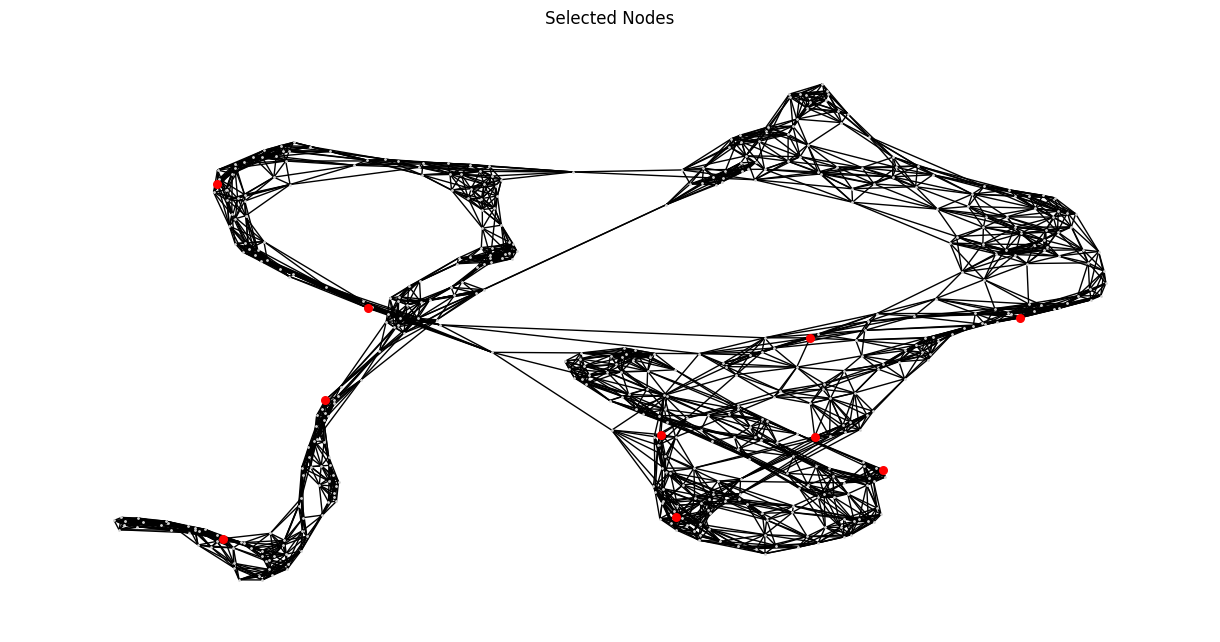

In [34]:
G2 = nx.Graph(W)

selected_subgraph = G2.subgraph(selected_nodes)  # Use the first set of selected nodes

# Define node positions for the layout
pos = nx.spring_layout(G2, seed=42)

# Plot the full graph
plt.figure(figsize=(12, 6))
nx.draw(G2, pos, with_labels=False, node_size=1, node_color='lightgray')
plt.title("Full Graph")

# Plot the selected nodes on top of the full graph
nx.draw(selected_subgraph, pos, with_labels=False, node_size=30, node_color='red')
plt.title("Selected Nodes")

plt.show()

/tmp/ipykernel_2467/3436421500.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap='Spectral')
/tmp/ipykernel_2467/3436421500.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[selected_nodes, 0], X[selected_nodes, 1], s=3, cmap='Spectral')


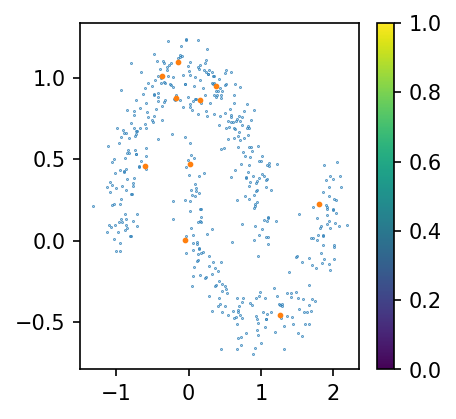

In [36]:
plt.figure(dpi=150, figsize=(3,3))
plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap='Spectral')
plt.scatter(X[selected_nodes, 0], X[selected_nodes, 1], s=3, cmap='Spectral')
#plt.scatter(embedding_norm[idx0,0], embedding_norm[idx0,1],  s=0.2, cmap='Spectral')
plt.colorbar()